In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

np.random.seed(2)

from sklearn.model_selection import train_test_split
import itertools
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
Y_train = train['label']
X_train = train.drop(labels=['label'], axis=1)
del train

In [4]:
X_train = X_train/255.0
test = test/255.0

In [5]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [6]:
#encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes=10)

In [7]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

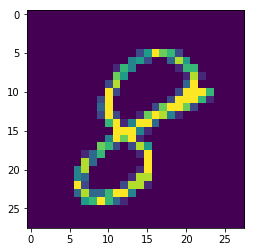

In [8]:
g = plt.imshow(X_train[0][:,:,0])

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs=5
batch_size=86

In [12]:
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False, vertical_flip=False)
datagen.fit(X_train)

In [13]:
# fit the model
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, Y_val), verbose=2, steps_per_epoch=X_train.shape[0], callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 748s - loss: 0.1074 - acc: 0.9758 - val_loss: 0.1204 - val_acc: 0.9876
Epoch 2/5
 - 733s - loss: 0.2365 - acc: 0.9640 - val_loss: 0.1991 - val_acc: 0.9831
Epoch 3/5
 - 732s - loss: 0.5196 - acc: 0.9599 - val_loss: 0.2188 - val_acc: 0.9864
Epoch 4/5
 - 732s - loss: 0.6686 - acc: 0.9584 - val_loss: 0.3684 - val_acc: 0.9771

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/5
 - 728s - loss: 0.4975 - acc: 0.9691 - val_loss: 0.4106 - val_acc: 0.9745


In [14]:
# predict results
res = model.predict(test)
res = np.argmax(res, axis=1)
res = pd.Series(res, name='Label')

In [15]:
submission = pd.concat([pd.Series(range(1,28001), name='ImageId'), res], axis=1)
submission.to_csv('generated_data.csv', index=False)